## Exploring Activations

I want to look at the activations generated by our network. This is mostly just out of curiosity since I wouldn't expect any big problems with ResNets.

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.callbacks import ActivationStats, HookCallback
from fastai.vision import *
import pandas as pd
import os

In [9]:
DATA = Path('data')
CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_TRN_MERGED = DATA/'train_merged.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'
TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

WORK = Path('work')
IMG_TRN_CURATED = WORK/'image/trn_curated'
IMG_TRN_NOISY = WORK/'image/trn_noisy'
IMG_TRN_MERGED = WORK/'image/trn_merged'
IMG_TEST = WORK/'image/test'
for folder in [WORK, IMG_TRN_CURATED, IMG_TRN_NOISY, IMG_TEST]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

train_df = pd.read_csv(CSV_TRN_CURATED)
train_noisy_df = pd.read_csv(CSV_TRN_NOISY)
test_df = pd.read_csv(CSV_SUBMISSION)

In [10]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
src = (ImageList.from_csv(WORK/'image', Path('../../')/CSV_TRN_CURATED, folder='trn_curated', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)

data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats)
)

In [31]:
# Modified from: https://forums.fast.ai/t/confused-by-output-of-hook-output/29514/4
class StoreHook(HookCallback):
    def on_train_begin(self, **kwargs):
        super().on_train_begin(**kwargs)
        self.hists = []
        
    def hook(self, m, i, o): 
        return o
    
    def on_batch_end(self, train, **kwargs): 
        if (train): 
            self.hists.append(self.hooks.stored[0].cpu().histc(40,0,10))
            

# Simply pass in a learner and the module you would like to instrument
def probeModule(learn, module):
    hook = StoreHook(learn, modules=flatten_model(module))
    learn.callbacks += [ hook ]
    return hook

# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): 
    return torch.stack(h.hists).t().float().log1p()

In [33]:
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[f_score])
learn.unfreeze()

In [34]:
#Hook the output of the first conv and each resnet block.
hooks = [probeModule(learn, learn.model[0][0]),
         probeModule(learn, learn.model[0][4]),
         probeModule(learn, learn.model[0][5]),
         probeModule(learn, learn.model[0][6]),
         probeModule(learn, learn.model[0][7])]

names = ['conv1',
         'conv2_x',
         'conv3_x',
         'conv4_x',
         'conv5_x']

learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,fbeta,time
0,0.642092,0.296679,0.072206,00:17
1,0.214200,0.071299,0.000000,00:17
2,0.109540,0.069773,0.012337,00:16
3,0.079462,0.067189,0.033778,00:15
4,0.068261,0.073749,0.061169,00:15
5,0.062447,0.058554,0.146483,00:16
6,0.058378,0.054290,0.105746,00:17
7,0.054267,0.050218,0.218822,00:17
8,0.050422,0.048071,0.273842,00:17
9,0.047923,0.045714,0.315618,00:17


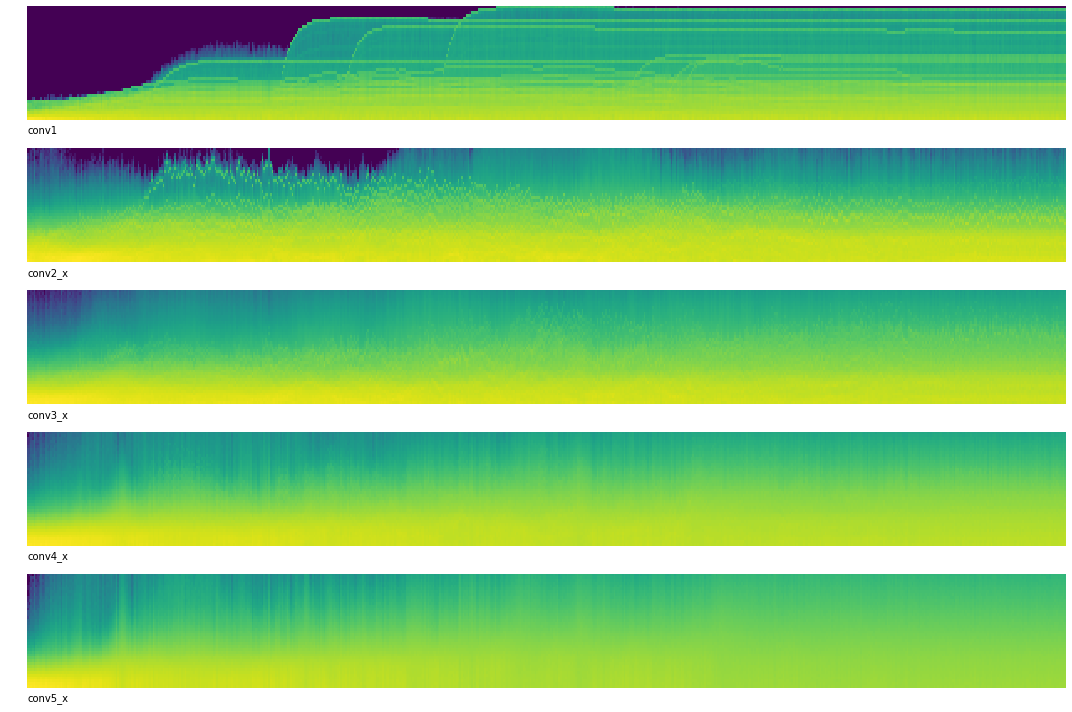

In [35]:
fig,axes = plt.subplots(5, figsize=(15,10))

for i, (ax,h) in enumerate(zip(axes.flatten(), hooks)):
    ax.imshow(get_hist(h), origin='lower', aspect='auto')
    ax.axis('off')
    ax.text(0, -5, names[i], bbox={'facecolor':'red', 'alpha':0.0, 'pad':10})
plt.tight_layout()

In [36]:
#Hook the output of the first conv and each resnet block.
hooks = [probeModule(learn, learn.model[0][0]),
         probeModule(learn, learn.model[0][4]),
         probeModule(learn, learn.model[0][5]),
         probeModule(learn, learn.model[0][6]),
         probeModule(learn, learn.model[0][7])]

names = ['conv1',
         'conv2_x',
         'conv3_x',
         'conv4_x',
         'conv5_x']

learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,fbeta,time
0,0.047124,0.045214,0.329863,00:22
1,0.047826,0.047175,0.334075,00:22
2,0.049196,0.045867,0.348026,00:22
3,0.047967,0.044315,0.355457,00:23
4,0.046266,0.043710,0.408864,00:23
5,0.044650,0.042024,0.424239,00:22
6,0.042561,0.040529,0.449082,00:22
7,0.040908,0.040273,0.437926,00:22
8,0.039411,0.039514,0.468207,00:22
9,0.038422,0.039550,0.460600,00:22


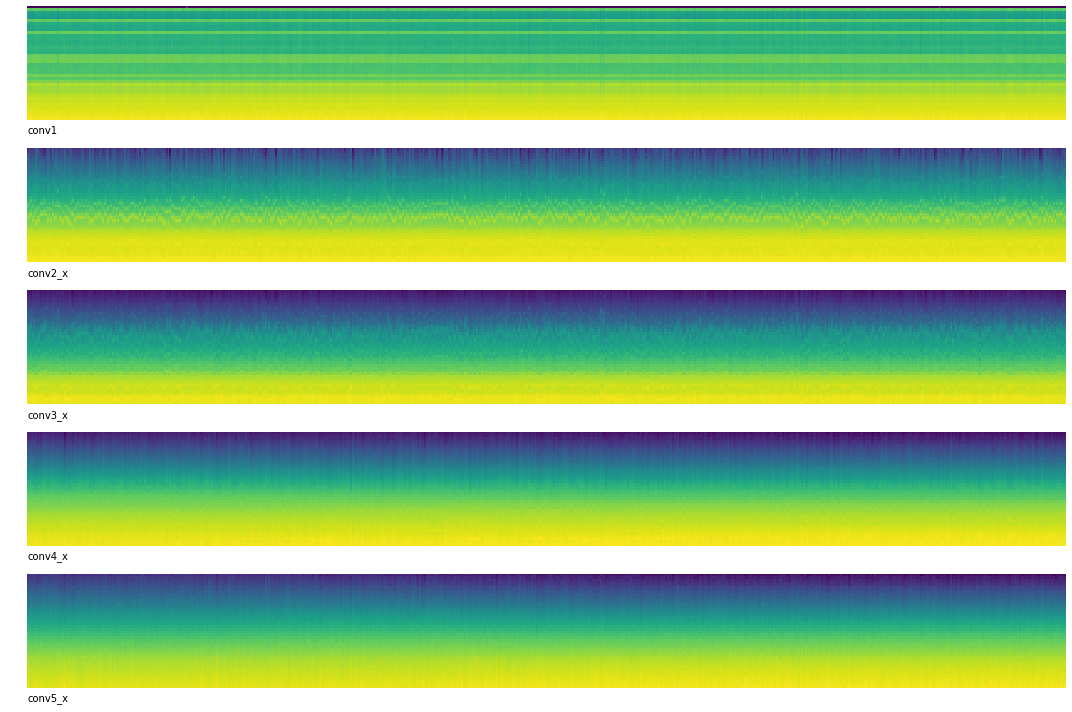

In [37]:
fig,axes = plt.subplots(5, figsize=(15,10))

for i, (ax,h) in enumerate(zip(axes.flatten(), hooks)):
    ax.imshow(get_hist(h), origin='lower', aspect='auto')
    ax.axis('off')
    ax.text(0, -5, names[i], bbox={'facecolor':'red', 'alpha':0.0, 'pad':10})
plt.tight_layout()